In [1]:
"""Cell 1: Setup and Imports"""
import sys
import os
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

warnings.filterwarnings('ignore')

# Ensure src is in path
src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Clear all qectostim module cache BEFORE importing (fresh start)
modules_to_clear = [k for k in list(sys.modules.keys()) if 'qectostim' in k]
for mod in modules_to_clear:
    del sys.modules[mod]

# Import testing utilities from qectostim.testing
from qectostim.testing import (
    clear_qectostim_modules,
    analyze_stim_circuit,
    test_code_circuit,
    CircuitAnalysis,
    STATUS_OK, STATUS_WARN, STATUS_SKIP, STATUS_FAIL,
)

# Import qectostim
from qectostim.codes import discover_all_codes
from qectostim.experiments.memory import CSSMemoryExperiment, StabilizerMemoryExperiment
from qectostim.noise.models import CircuitDepolarizingNoise

print("✓ All imports successful")
print(f"  analyze_stim_circuit: {analyze_stim_circuit}")
print(f"  discover_all_codes: {discover_all_codes}")
print(f"  CircuitAnalysis fields: {[f.name for f in CircuitAnalysis.__dataclass_fields__.values()][:10]}...")

✓ All imports successful
  analyze_stim_circuit: <function analyze_stim_circuit at 0x1079d3100>
  discover_all_codes: <function discover_all_codes at 0x107a42de0>
  CircuitAnalysis fields: ['num_qubits', 'num_detectors', 'num_observables', 'circuit_depth', 'num_ticks', 'gate_counts', 'two_qubit_gates', 'single_qubit_gates', 'has_qubit_coords', 'qubit_coords']...


In [2]:
"""Cell 2: Discover All Codes"""
clear_output(wait=True)

print("="*70)
print("DISCOVERING ALL CODES")
print("="*70)

# Discover codes with reasonable size limit
codes = discover_all_codes(
    max_qubits=100,
    include_qldpc=True,
    include_subsystem=True,
    include_floquet=True,
    timeout_per_code=5.0,
)

print(f"\nDiscovered {len(codes)} codes")

# Categorize by type for display
code_types = {}
for name, code in codes.items():
    # Determine type
    if 'Floquet' in name or 'Honeycomb' in name:
        ctype = 'Floquet'
    elif 'Subsystem' in name or 'Gauge' in name or 'Bacon' in name:
        ctype = 'Subsystem'
    elif any(x in name for x in ['HGP', 'BB', 'GB', 'Hypergraph', 'Bicycle', 'Lifted']):
        ctype = 'QLDPC'
    elif any(x in name for x in ['Color', 'Steane', '488', '666']):
        ctype = 'Color'
    elif hasattr(code, 'hx') and hasattr(code, 'hz'):
        ctype = 'CSS'
    else:
        ctype = 'Other'
    
    if ctype not in code_types:
        code_types[ctype] = []
    code_types[ctype].append((name, code))

print("\nBy type:")
for ctype, code_list in sorted(code_types.items()):
    print(f"  {ctype}: {len(code_list)}")

print("\n" + "-"*70)
print(f"{'Code Name':<40} {'n':>4} {'k':>3} {'d':>3}")
print("-"*70)
for name, code in sorted(codes.items())[:15]:
    d = code.metadata.get('distance', '?')
    print(f"{name:<40} {code.n:>4} {code.k:>3} {d:>3}")
if len(codes) > 15:
    print(f"... and {len(codes) - 15} more")

DISCOVERING ALL CODES

Discovered 60 codes

By type:
  CSS: 42
  Color: 4
  Floquet: 1
  Other: 5
  QLDPC: 4
  Subsystem: 4

----------------------------------------------------------------------
Code Name                                   n   k   d
----------------------------------------------------------------------
BaconShor_3x3                               9   5   3
BalancedProduct_5x5_G1                     41   1   4
BalancedProduct_7x7_G1                     58  16   5
BareAncilla_713                             7   1   3
C6                                          6   2   2
CampbellDoubleHGP_3_[[13,1,None]]          13   1   ?
CampbellDoubleHGP_5_[[41,1,None]]          41   1   ?
Code_832                                    8   3   2
Colour488_[[9,1,3]]                         9   1   3
DLV_8                                      58  16   3
DoublePinCode_d3                           13   1   3
DoublePinCode_d5                           41   1   5
FourQubit422_[[4,2,2]]         

In [3]:
"""Cell 3: Analyze Circuit Properties for All Codes"""
clear_output(wait=True)

print("="*70)
print("ANALYZING STIM CIRCUITS")
print("="*70)

# Configuration
p = 0.001  # Low noise for clean circuit analysis
rounds = 3

# Store results
circuit_results = {}

for i, (name, code) in enumerate(sorted(codes.items())):
    print(f"\r[{i+1}/{len(codes)}] Analyzing {name}...", end='', flush=True)
    
    result = {
        'status': 'UNKNOWN',
        'n': code.n,
        'k': code.k,
        'd': code.metadata.get('distance', '?'),
        'analysis': None,
        'error': None,
    }
    
    try:
        noise = CircuitDepolarizingNoise(p1=p, p2=p)
        
        # Build circuit
        if hasattr(code, 'hx') and hasattr(code, 'hz'):
            exp = CSSMemoryExperiment(code=code, rounds=rounds, noise_model=noise)
        else:
            exp = StabilizerMemoryExperiment(code=code, rounds=rounds, noise_model=noise)
        
        circuit = exp.to_stim()
        
        # Analyze
        analysis = analyze_stim_circuit(circuit)
        result['analysis'] = analysis
        result['circuit'] = circuit  # Store for later visualization
        
        # Determine status
        if analysis.parallelism_score < 2.0:
            result['status'] = 'WARN'  # Low parallelism
        elif not analysis.has_qubit_coords:
            result['status'] = 'WARN'  # Missing coords
        else:
            result['status'] = 'OK'
            
    except Exception as e:
        result['status'] = 'FAIL'
        result['error'] = f"{type(e).__name__}: {str(e)[:50]}"
    
    circuit_results[name] = result

print("\n\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

# Summary
ok = sum(1 for r in circuit_results.values() if r['status'] == 'OK')
warn = sum(1 for r in circuit_results.values() if r['status'] == 'WARN')
fail = sum(1 for r in circuit_results.values() if r['status'] == 'FAIL')

print(f"\n{STATUS_OK} OK: {ok}")
print(f"{STATUS_WARN} WARN: {warn} (low parallelism or missing coords)")
print(f"{STATUS_FAIL} FAIL: {fail}")

ANALYZING STIM CIRCUITS
[60/60] Analyzing XZZX_Surface_5...[[32,2,None]]....]]...

ANALYSIS COMPLETE

✓ OK: 30
⚠️ WARN: 29 (low parallelism or missing coords)
✗ FAIL: 1


ANALYSIS COMPLETE

✓ OK: 30
⚠️ WARN: 29 (low parallelism or missing coords)
✗ FAIL: 1


In [4]:
"""Cell 4: Results Table - Circuit Properties"""
clear_output(wait=True)

print("="*160)
print("CIRCUIT ANALYSIS TABLE")
print("="*160)
print("")
print("Metrics:")
print("  - Ticks: Number of TICK instructions (explicit timing layers)")
print("  - GateD: Estimated gate depth (if no TICKs, estimated from gate counts)")
print("  - 2Q: Two-qubit gate count")
print("  - 1Q: Single-qubit gate count")
print("  - Util: Layer utilization (avg ops per tick / num_qubits)")
print("  - Timed: ✓ if circuit has TICK instructions, ✗ if untimed")
print("  - Coords: Has QUBIT_COORDS (✓/✗)")
print("")

# Header
header = f"{'Code':<40} | {'n':>4} | {'k':>2} | {'d':>3} | {'Ticks':>5} | {'GateD':>5} | {'2Q':>6} | {'1Q':>6} | {'Util':>5} | {'Timed':>5} | {'Coords':>6} | Status"
print(header)
print("-" * len(header))

# Sort by has_timing first (timed circuits first), then by gate_depth
def sort_key(item):
    name, r = item
    if r['analysis']:
        a = r['analysis']
        # Timed circuits first (0), then untimed (1)
        # Then sort by gate depth ascending
        return (0 if a.has_timing else 1, a.circuit_depth)
    return (2, 0)

for name, r in sorted(circuit_results.items(), key=sort_key):
    n = r['n']
    k = r['k']
    d = r['d']
    
    if r['analysis']:
        a = r['analysis']
        ticks = a.num_ticks if a.has_timing else 0
        gate_depth = a.gate_depth if hasattr(a, 'gate_depth') and a.gate_depth > 0 else a.circuit_depth
        twoq = a.two_qubit_gates
        oneq = a.single_qubit_gates
        util = f"{a.layer_utilization:.2f}" if hasattr(a, 'layer_utilization') and a.layer_utilization > 0 else "-"
        timed = STATUS_OK if a.has_timing else STATUS_FAIL
        coords = STATUS_OK if a.has_qubit_coords else STATUS_FAIL
    else:
        ticks = '-'
        gate_depth = '-'
        twoq = '-'
        oneq = '-'
        util = '-'
        timed = '-'
        coords = '-'
    
    # Status indicator
    if r['status'] == 'OK':
        status = f"{STATUS_OK} OK"
    elif r['status'] == 'WARN':
        status = f"{STATUS_WARN} WARN"
    else:
        status = f"{STATUS_FAIL} FAIL"
        if r['error']:
            status += f" ({r['error'][:20]})"
    
    row = f"{name:<40} | {n:>4} | {k:>2} | {str(d):>3} | {str(ticks):>5} | {str(gate_depth):>5} | {str(twoq):>6} | {str(oneq):>6} | {str(util):>5} | {str(timed):>5} | {str(coords):>6} | {status}"
    print(row)

print("-" * len(header))

# Count statistics
timed_count = sum(1 for r in circuit_results.values() if r['analysis'] and r['analysis'].has_timing)
untimed_count = sum(1 for r in circuit_results.values() if r['analysis'] and not r['analysis'].has_timing)
failed_count = sum(1 for r in circuit_results.values() if r['status'] == 'FAIL')

print(f"\nTotal: {len(circuit_results)} codes analyzed")
print(f"  {STATUS_OK} Timed circuits (have TICKs): {timed_count}")
print(f"  {STATUS_WARN} Untimed circuits (no TICKs): {untimed_count}")
print(f"  {STATUS_FAIL} Failed: {failed_count}")

CIRCUIT ANALYSIS TABLE

Metrics:
  - Ticks: Number of TICK instructions (explicit timing layers)
  - GateD: Estimated gate depth (if no TICKs, estimated from gate counts)
  - 2Q: Two-qubit gate count
  - 1Q: Single-qubit gate count
  - Util: Layer utilization (avg ops per tick / num_qubits)
  - Timed: ✓ if circuit has TICK instructions, ✗ if untimed
  - Coords: Has QUBIT_COORDS (✓/✗)

Code                                     |    n |  k |   d | Ticks | GateD |     2Q |     1Q |  Util | Timed | Coords | Status
------------------------------------------------------------------------------------------------------------------------------
Shor_91                                  |    9 |  1 |   3 |     7 |    10 |     48 |     62 |  0.81 |     ✓ |      ✓ | ✓ OK
Repetition_3                             |    3 |  1 |   3 |    10 |     9 |     12 |     14 |  0.74 |     ✓ |      ✓ | ✓ OK
Repetition_5                             |    5 |  1 |   5 |    10 |     9 |     24 |     26 |  0.79 |     ✓

In [16]:
"""Cell 5: Parallelism and Timing Analysis"""
clear_output(wait=True)

print("="*80)
print("CIRCUIT TIMING AND PARALLELISM ANALYSIS")
print("="*80)

# Debug: Check a few circuits
print("\nDEBUG: Checking timing data for sample circuits:")
for name, r in list(circuit_results.items())[:5]:
    if r['analysis']:
        a = r['analysis']
        print(f"  {name}: num_ticks={a.num_ticks}, ops_per_tick={a.ops_per_tick[:3] if len(a.ops_per_tick) > 3 else a.ops_per_tick}, has_timing={a.has_timing}")

# Separate by timing status first
timed_circuits = []
untimed_circuits = []

for name, r in circuit_results.items():
    if r['analysis']:
        if r['analysis'].has_timing:
            timed_circuits.append((name, r))
        else:
            untimed_circuits.append((name, r))

print(f"\n{'='*80}")
print("TIMED CIRCUITS (have multiple TICK layers)")
print("="*80)
print(f"Found {len(timed_circuits)} circuits with proper timing structure.\n")

if timed_circuits:
    # Sort timed circuits by layer utilization
    timed_circuits.sort(key=lambda x: -x[1]['analysis'].layer_utilization if x[1]['analysis'].layer_utilization else 0)

    print(f"{'Code':<40} {'Ticks':>6} {'Layers':>6} {'Util':>6} {'2Q':>6} {'1Q':>6}")
    print("-" * 75)
    for name, r in timed_circuits:
        a = r['analysis']
        util = f"{a.layer_utilization:.2f}" if a.layer_utilization else "-"
        num_layers = len(a.ops_per_tick)
        print(f"{name:<40} {a.num_ticks:>6} {num_layers:>6} {util:>6} {a.two_qubit_gates:>6} {a.single_qubit_gates:>6}")
    # if len(timed_circuits) > 20:
    #     print(f"... and {len(timed_circuits) - 20} more")

print(f"\n{'='*80}")
print("UNTIMED CIRCUITS (single layer or no TICKs)")
print("="*80)
print(f"Found {len(untimed_circuits)} circuits without multi-layer timing structure.")
print("These circuits have all ops in a single layer - need better TICK placement.\n")

if untimed_circuits:
    # Sort untimed by estimated gate depth
    untimed_circuits.sort(key=lambda x: -(x[1]['analysis'].gate_depth if hasattr(x[1]['analysis'], 'gate_depth') and x[1]['analysis'].gate_depth else 0))

    print(f"{'Code':<40} {'EstDepth':>8} {'2QDepth':>8} {'2Q':>6} {'1Q':>6} {'TotalOps':>8}")
    print("-" * 80)
    for name, r in untimed_circuits:
        a = r['analysis']
        gate_d = a.gate_depth if hasattr(a, 'gate_depth') and a.gate_depth else a.circuit_depth
        twoq_d = a.two_qubit_depth if hasattr(a, 'two_qubit_depth') else '-'
        total = a.total_ops if hasattr(a, 'total_ops') else a.two_qubit_gates + a.single_qubit_gates
        print(f"{name:<40} {gate_d:>8} {str(twoq_d):>8} {a.two_qubit_gates:>6} {a.single_qubit_gates:>6} {total:>8}")
    # if len(untimed_circuits) > 25:
    #     print(f"... and {len(untimed_circuits) - 25} more")

CIRCUIT TIMING AND PARALLELISM ANALYSIS

DEBUG: Checking timing data for sample circuits:
  BaconShor_3x3: num_ticks=34, ops_per_tick=[13, 8, 6], has_timing=True
  BalancedProduct_5x5_G1: num_ticks=22, ops_per_tick=[81, 80, 60], has_timing=True
  BalancedProduct_7x7_G1: num_ticks=52, ops_per_tick=[100, 84, 63], has_timing=True
  BareAncilla_713: num_ticks=13, ops_per_tick=[14, 6, 18], has_timing=True
  C6: num_ticks=19, ops_per_tick=[10, 8, 6], has_timing=True

TIMED CIRCUITS (have multiple TICK layers)
Found 59 circuits with proper timing structure.

Code                                      Ticks Layers   Util     2Q     1Q
---------------------------------------------------------------------------
Mixed_512                                    10     11   0.91     24     66
NonCSS_1023                                  10     11   0.88     48    126
Repetition_7                                 10      7   0.81     36     38
Shor_91                                       7      8   0.81 

Found 30 codes with QUBIT_COORDS



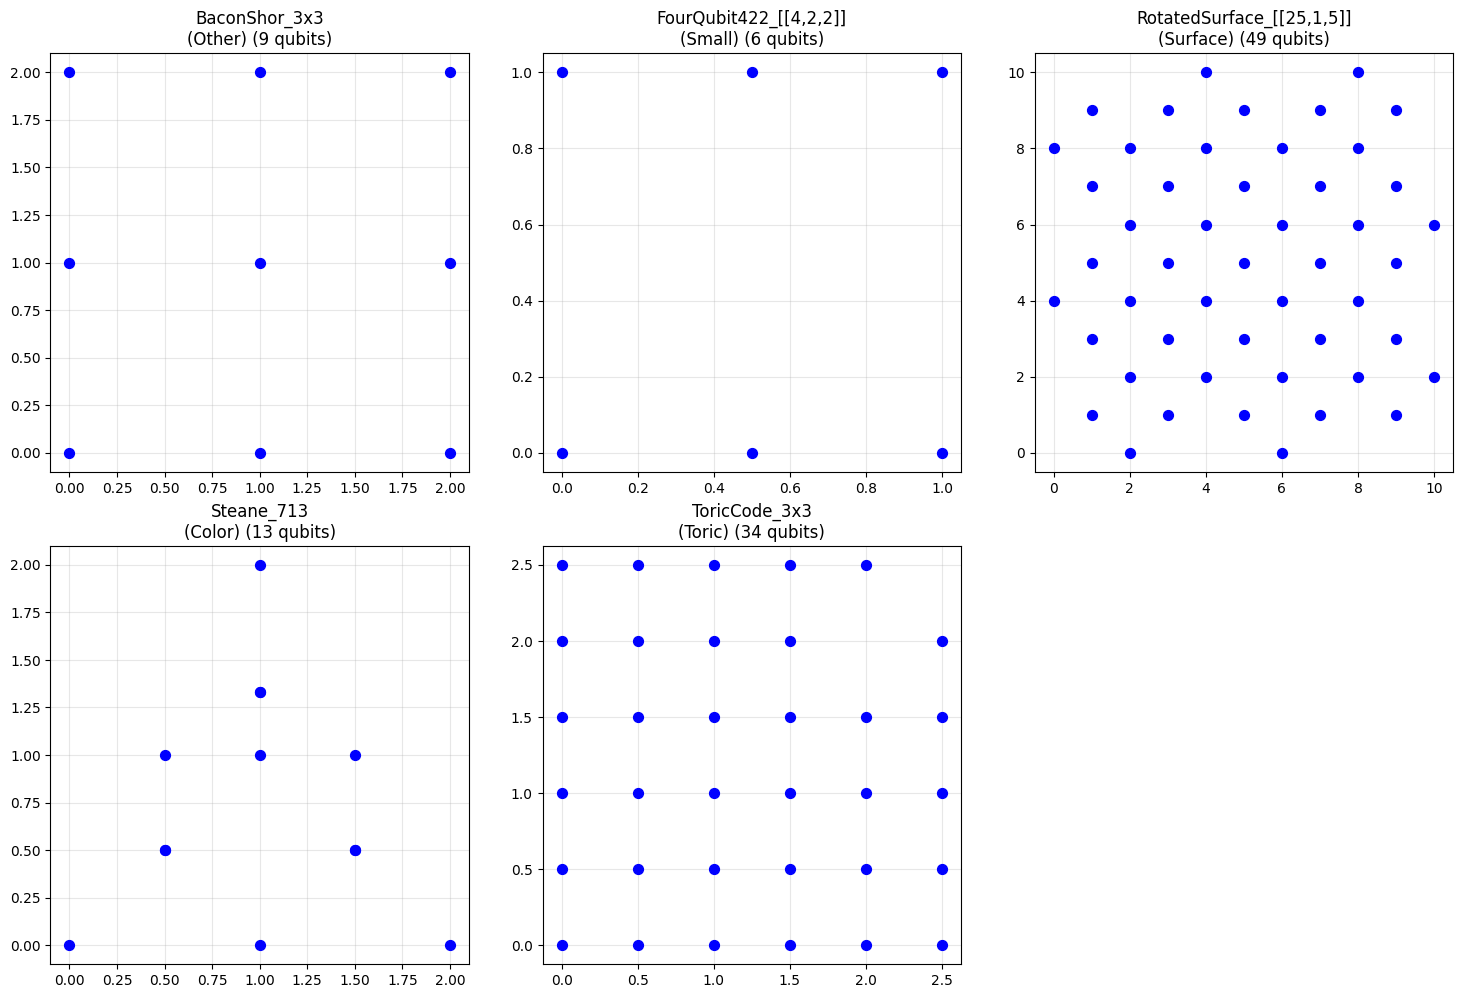

In [6]:
"""Cell 6: Visualize Qubit Topology for Selected Codes"""
from qectostim.testing import plot_qubit_topology

# Select codes with coordinates for visualization
codes_with_coords = [
    (name, r) for name, r in circuit_results.items()
    if r['analysis'] and r['analysis'].has_qubit_coords and 'circuit' in r
]

print(f"Found {len(codes_with_coords)} codes with QUBIT_COORDS\n")

# Plot a selection (different types)
codes_to_plot = []
types_seen = set()

for name, r in codes_with_coords:
    # Get type
    if 'Surface' in name:
        ctype = 'Surface'
    elif 'Color' in name or 'Steane' in name:
        ctype = 'Color'
    elif 'HGP' in name or 'Hypergraph' in name:
        ctype = 'QLDPC'
    elif 'Toric' in name:
        ctype = 'Toric'
    elif '422' in name or '513' in name:
        ctype = 'Small'
    else:
        ctype = 'Other'
    
    if ctype not in types_seen:
        codes_to_plot.append((name, r, ctype))
        types_seen.add(ctype)
    
    if len(codes_to_plot) >= 6:
        break

if codes_to_plot:
    n_plots = len(codes_to_plot)
    cols = min(3, n_plots)
    rows = (n_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, (name, r, ctype) in enumerate(codes_to_plot):
        circuit = r['circuit']
        plot_qubit_topology(
            circuit,
            ax=axes[i],
            title=f"{name}\n({ctype})",
            show_qubit_ids=False,
        )
    
    # Hide unused axes
    for i in range(len(codes_to_plot), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No codes with QUBIT_COORDS found for visualization.")

In [7]:
"""Cell 7: Gate Count Distribution"""
print("="*70)
print("GATE COUNT DISTRIBUTION")
print("="*70)

# Aggregate gate counts across all codes
total_gates = {}
for name, r in circuit_results.items():
    if r['analysis']:
        for gate, count in r['analysis'].gate_counts.items():
            total_gates[gate] = total_gates.get(gate, 0) + count

# Sort by count
sorted_gates = sorted(total_gates.items(), key=lambda x: -x[1])

print(f"\n{'Gate':<20} {'Total Count':>15} {'% of Total':>12}")
print("-" * 50)

total = sum(total_gates.values())
for gate, count in sorted_gates[:15]:
    pct = 100 * count / total if total > 0 else 0
    print(f"{gate:<20} {count:>15,} {pct:>11.1f}%")

if len(sorted_gates) > 15:
    print(f"... and {len(sorted_gates) - 15} more gate types")

print("-" * 50)
print(f"{'TOTAL':<20} {total:>15,}")

GATE COUNT DISTRIBUTION

Gate                     Total Count   % of Total
--------------------------------------------------
CX                             1,494        43.5%
H                              1,478        43.0%
MR                               330         9.6%
R                                 74         2.2%
M                                 59         1.7%
--------------------------------------------------
TOTAL                          3,435


In [8]:
"""Cell 8: Summary and Recommendations"""
print("="*70)
print("CIRCUIT ANALYSIS SUMMARY")
print("="*70)

# Count statistics
total = len(circuit_results)
has_coords = sum(1 for r in circuit_results.values() if r['analysis'] and r['analysis'].has_qubit_coords)
has_timing = sum(1 for r in circuit_results.values() if r['analysis'] and r['analysis'].has_timing)
no_timing = sum(1 for r in circuit_results.values() if r['analysis'] and not r['analysis'].has_timing)
failed = sum(1 for r in circuit_results.values() if r['status'] == 'FAIL')

print(f"\nTotal codes analyzed: {total}")
print(f"\n{STATUS_OK} Circuit Generation:")
print(f"   Successfully built: {total - failed} ({100*(total-failed)/total:.0f}%)")
print(f"   Failed: {failed}")

print(f"\n{STATUS_OK} Timing Structure:")
print(f"   Properly timed (multiple TICKs): {has_timing} ({100*has_timing/(total-failed):.0f}%)" if total > failed else "")
print(f"   Untimed (single layer): {no_timing} - need TICK insertion")

print(f"\n{STATUS_OK} QUBIT_COORDS:")
print(f"   Has coordinates: {has_coords} ({100*has_coords/total:.0f}%)")
print(f"   Missing coordinates: {total - has_coords}")

# Recommendations
print("\n" + "="*70)
print("RECOMMENDATIONS")
print("="*70)

if no_timing > 0:
    print(f"\n{STATUS_FAIL} Add TICK instructions to {no_timing} circuits for proper timing")
    print("   These circuits have all gates in 1-2 layers, making depth analysis impossible.")
    untimed_list = [(name, r) for name, r in circuit_results.items() 
                    if r['analysis'] and not r['analysis'].has_timing]
    untimed_list.sort(key=lambda x: -x[1]['analysis'].total_ops)
    for name, r in untimed_list[:5]:
        a = r['analysis']
        print(f"     - {name}: {a.total_ops} ops in {len(a.ops_per_tick)} layers (est. depth: {a.gate_depth})")

if total - has_coords > 0:
    print(f"\n{STATUS_WARN} Add QUBIT_COORDS to {total - has_coords} codes for visualization support")
    missing = [name for name, r in circuit_results.items() 
               if r['analysis'] and not r['analysis'].has_qubit_coords][:5]
    for name in missing:
        print(f"     - {name}")

if failed > 0:
    print(f"\n{STATUS_FAIL} Fix circuit generation for {failed} codes")
    for name, r in list(circuit_results.items())[:5]:
        if r['status'] == 'FAIL':
            print(f"     - {name}: {r['error'][:50]}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

CIRCUIT ANALYSIS SUMMARY

Total codes analyzed: 60

✓ Circuit Generation:
   Successfully built: 59 (98%)
   Failed: 1

✓ Timing Structure:
   Properly timed (multiple TICKs): 59 (100%)
   Untimed (single layer): 0 - need TICK insertion

✓ QUBIT_COORDS:
   Has coordinates: 30 (50%)
   Missing coordinates: 30

RECOMMENDATIONS

⚠️ Add QUBIT_COORDS to 30 codes for visualization support
     - BalancedProduct_5x5_G1
     - BalancedProduct_7x7_G1
     - CampbellDoubleHGP_3_[[13,1,None]]
     - CampbellDoubleHGP_5_[[41,1,None]]
     - DLV_8

✗ Fix circuit generation for 1 codes

ANALYSIS COMPLETE


In [13]:
"""Test new qubit_coords implementations for surface codes"""

# Reload modules to pick up changes
import sys
modules_to_clear = [k for k in list(sys.modules.keys()) if 'qectostim' in k]
for mod in modules_to_clear:
    del sys.modules[mod]

# Now import fresh
from qectostim.codes.surface.exotic_surface import (
    FractalSurfaceCode, TwistedToricCode, ProjectivePlaneSurfaceCode, LCSCode
)
from qectostim.codes.surface.hyperbolic import (
    Hyperbolic45Code, FreedmanMeyerLuoCode, GuthLubotzkyCode, GoldenCode
)

codes_to_test = [
    ("FractalSurfaceCode(level=2)", FractalSurfaceCode(level=2)),
    ("TwistedToricCode(Lx=4, Ly=4)", TwistedToricCode(Lx=4, Ly=4)),
    ("ProjectivePlaneSurfaceCode(L=4)", ProjectivePlaneSurfaceCode(L=4)),
    ("LCSCode(n_layers=3, L=3)", LCSCode(n_layers=3, L=3)),
    ("Hyperbolic45Code(genus=2)", Hyperbolic45Code(genus=2)),
    ("FreedmanMeyerLuoCode(L=4)", FreedmanMeyerLuoCode(L=4)),
    ("GuthLubotzkyCode(L=4)", GuthLubotzkyCode(L=4)),
    ("GoldenCode(L=5)", GoldenCode(L=5)),
]

print("="*70)
print("TESTING qubit_coords FOR SURFACE/HYPERBOLIC CODES")
print("="*70)
all_ok = True
for name, code in codes_to_test:
    try:
        coords = code.qubit_coords()
        if coords is None:
            print(f"? {name}: n={code.n}, coords=None")
            continue
        ok = len(coords) == code.n
        status = "✓" if ok else "✗"
        print(f"{status} {name}: n={code.n}, coords={len(coords)}")
        if not ok:
            all_ok = False
    except Exception as e:
        print(f"✗ {name}: ERROR - {e}")
        all_ok = False

print("-" * 70)
print(f"All tests passed: {all_ok}")

TESTING qubit_coords FOR SURFACE/HYPERBOLIC CODES
✓ FractalSurfaceCode(level=2): n=88, coords=88
✓ TwistedToricCode(Lx=4, Ly=4): n=32, coords=32
✓ ProjectivePlaneSurfaceCode(L=4): n=25, coords=25
✓ LCSCode(n_layers=3, L=3): n=60, coords=60
✓ Hyperbolic45Code(genus=2): n=25, coords=25
✓ FreedmanMeyerLuoCode(L=4): n=656, coords=656
✓ GuthLubotzkyCode(L=4): n=400, coords=400
✓ GoldenCode(L=5): n=77, coords=77
----------------------------------------------------------------------
All tests passed: True
